In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_palette("Set2")

# Introduction
In this notebook, we are going to explore three supervised learning models and their respective hyperparameters. These models are: **Decision Tree**, **K-Nearest Neighbors** and **Support Vector Machine**. The first section will consist of an Exploratory Data Analysis and feature selection. The second section will be about training the models, their hyperparameters and then comparing the three models together. After which, we will select the best model and submit our results to Kaggle.

# The Dataset
You can find the dataset we used here: https://www.kaggle.com/competitions/spaceship-titanic/overview 
It is a spinoff on the classic Titanic Dataset, but with far more rows and attributes. It involves a ficticious spaceship that experiences a catastrophe where passengers were transported to an alternate dimension. Each entry has information on the type of passenger, their home planet, destination, VIP status and more. We are going to use these attributes to predict whether someone was transported or not.

This dataset is ideal because it has minimal categorical variables to encode and is easy to understand, so we can spend more time and energy working with the model and hyperparameters.

In [2]:
#Load the data and drop any rows with null values
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.dropna(inplace=True)
test.dropna(inplace=True)

In [3]:
# The Cabin and Passenger columns include dense information. Cabins have a deck, number and side while passengers have group.
# We are splitting this information into different columns.

train['Cabin'] = train['Cabin'].fillna(method='bfill')
train['Cabin Deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin Num'] = train['Cabin'].apply(lambda x: x.split('/')[1])
train['Cabin Side'] = train['Cabin'].apply(lambda x: x.split('/')[2])
train[["FirstName","LastName"]] = train['Name'].str.split(' ', 1, expand=True)
train['Total Spent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa']
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0])

test['Cabin'] = test['Cabin'].fillna(method='bfill')
test['Cabin Deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin Num'] = test['Cabin'].apply(lambda x: x.split('/')[1])
test['Cabin Side'] = test['Cabin'].apply(lambda x: x.split('/')[2])
test[["FirstName","LastName"]] = test['Name'].str.split(' ', 1, expand=True)
test['Total Spent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa']
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0])

train.drop('PassengerId', axis =1, inplace = True)
test.drop('PassengerId', axis = 1, inplace = True)

In [4]:
print("Num rows: ", train.shape[0])
print("Num features: ", train.shape[1])

Num rows:  6606
Num features:  20


In [5]:
# List of attributes
train.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'Cabin Deck', 'Cabin Num', 'Cabin Side', 'FirstName',
       'LastName', 'Total Spent', 'Group'],
      dtype='object')

# Exploratory Data Analysis

<AxesSubplot:xlabel='Cabin Side', ylabel='count'>

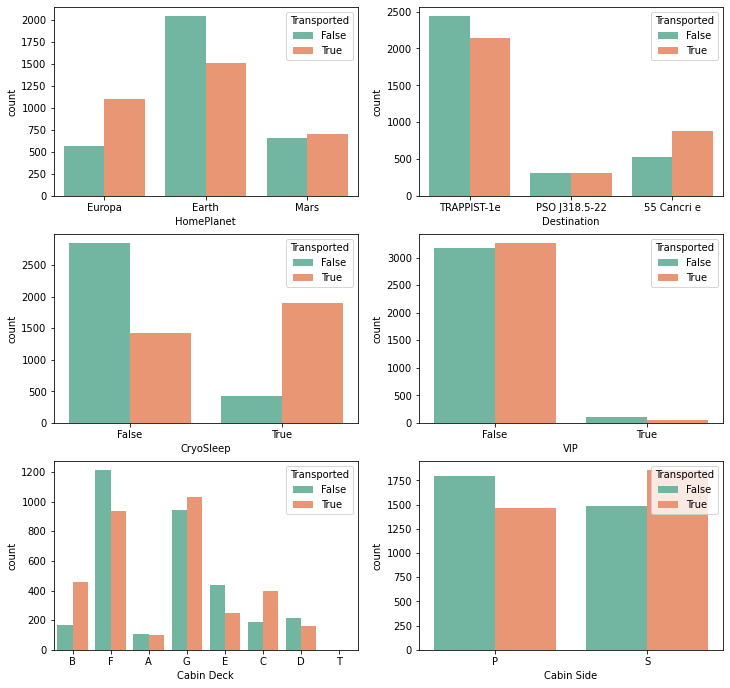

In [6]:
plt.figure(figsize=(12,16))

plt.subplot(4,2,1)
sns.countplot(x="HomePlanet", data=train, hue="Transported")
plt.subplot(4,2,2)
sns.countplot(x="Destination", data=train, hue="Transported")
plt.subplot(4,2,3)
sns.countplot(x="CryoSleep", data=train, hue="Transported")
plt.subplot(4,2,4)
sns.countplot(x="VIP", data=train, hue="Transported")
plt.subplot(4,2,5)
sns.countplot(x="Cabin Deck", data=train, hue="Transported")
plt.subplot(4,2,6)
sns.countplot(x="Cabin Side", data=train, hue="Transported")

<AxesSubplot:xlabel='Age', ylabel='Count'>

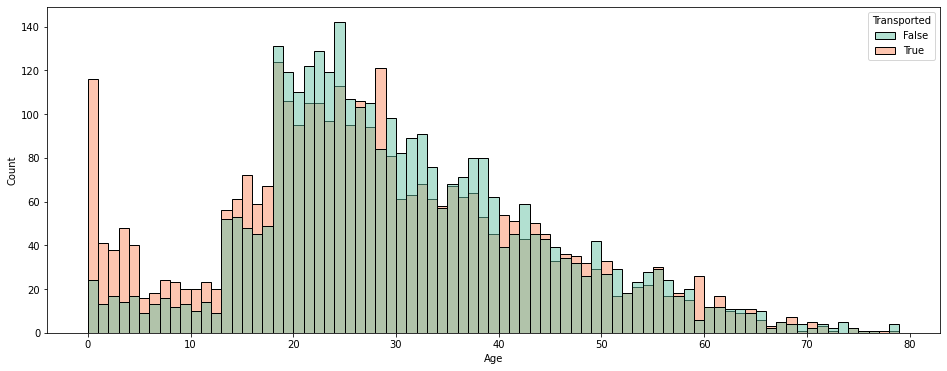

In [7]:
plt.figure(figsize=(16,6))

sns.histplot(data=train, x='Age', hue='Transported', binwidth=1)

## Results of Exploratory Data Analysis
 Passengers between ages 0 to 20 were far more likely to be transported. Cabin Decks A, C and G and Cabin Side S had more transported passengers. Passengers in Cryosleep are far more likely to be transported. Home Planet and Destination do not have a significant influence on transport numbers. VIP status does; there are far less VIPs who were transported than otherwise.

# Feature Selection
We are going to use the results of the EDA to select features. 

In [8]:
# Encoding categorical variables into one-hot vectors and dropping features that will not aid in prediction.
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent'], axis=1)
train_OH_encodings = pd.get_dummies(train[['HomePlanet','Destination','Cabin Deck','Cabin Side']])
test_OH_encodings = pd.get_dummies(test[['HomePlanet','Destination','Cabin Deck','Cabin Side']])

train.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
test.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)
test.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)

train = train.join(train_OH_encodings)
test = test.join(test_OH_encodings)

In [9]:
# Changing booleans into ints
train['CryoSleep'] = train['CryoSleep'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['Transported'] = train['Transported'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)
test['VIP'] = test['VIP'].astype(int)

### The features we will use:

In [10]:
train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin Num', 'Group',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin Deck_A', 'Cabin Deck_B',
       'Cabin Deck_C', 'Cabin Deck_D', 'Cabin Deck_E', 'Cabin Deck_F',
       'Cabin Deck_G', 'Cabin Deck_T', 'Cabin Side_P', 'Cabin Side_S'],
      dtype='object')

# Models
To find the best hyperparameters, we will be using Grid Search and Cross Validation. This will allow us to try every possible combination of hyperparamters and train/validation splits. For each model, we'll have a table showing the scores for each hyperparamater permutation and the mean score for their cross validation splits. We will also go into detail on how each model works and what effect their hyperparameters have on them.

In [11]:
features = list(train.columns)
features.remove('Transported')
X = train[features]
y = train['Transported']
train_X, val_X, train_y, val_y = train_test_split(X, y)

In [61]:
#Decision Tree

hyperparameters = {
    'max_depth': [7, 8, 9, 10, 11, 12],
    'min_samples_split':[8, 9, 10, 11, 12],
    'min_samples_leaf': [3, 5, 6, 7],
    "random_state": [12]
}

dt = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt, hyperparameters, cv=10, n_jobs=-1)
dt_model = dt_clf.fit(train_X, train_y)

dt_model_scores = pd.DataFrame(dt_model.cv_results_)
dt_model_scores[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score
52,9,10,6,0.783612
51,9,9,6,0.783612
50,9,8,6,0.783612
53,9,11,6,0.783612
54,9,12,6,0.783612
...,...,...,...,...
82,11,10,3,0.768268
103,12,11,3,0.768067
84,11,12,3,0.767866
104,12,12,3,0.767059


In [75]:
def print_scores(hyperparameters=None):
    if isinstance(hyperparameters, dict):
        dt_model = DecisionTreeClassifier(**hyperparameters)
    else:
        dt_model = DecisionTreeClassifier()
        
    dt_model.fit(train_X, train_y)

    train_score = accuracy_score(dt_model.predict(train_X), train_y)
    test_score = dt_model.score(val_X, val_y)
    overfit = train_score - test_score

    print(hyperparameters)
    print("\ttrain score: {:.2f}%".format(train_score * 100))
    print("\ttest score: {:.2f}%".format(test_score* 100))
    print("\toverfit: {:.2f}%".format((train_score - test_score) * 100))


def test_max_depth(md: int, hyperparameters=None):
    if isinstance(hyperparameters, dict):
        hyperparameters['max_depth'] = md
        hyperparameters['random_state'] = 12
        dt_model = DecisionTreeClassifier(**hyperparameters)
    else:
        dt_model = DecisionTreeClassifier(max_depth=md, random_state=12)
    dt_model.fit(train_X, train_y)
    train_score = accuracy_score(dt_model.predict(train_X), train_y)
    test_score = dt_model.score(val_X, val_y)
    overfit = train_score - test_score
    return {"max depth": md, "train_score": train_score, "test_score": test_score, "overfit": overfit}

def plot_df(df):
    plt.figure()
    plt.plot(df["max depth"], df["train_score"])
    plt.plot(df["max depth"], df["test_score"])
    plt.title("Training vs Tests Score")
    plt.xlabel("max depth")
    plt.ylabel("score")
    plt.legend(['training', 'test'])


{'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'random_state': 12}
	train score: 83.06%
	test score: 80.21%
	overfit: 2.86%
None
	train score: 99.98%
	test score: 75.48%
	overfit: 24.50%


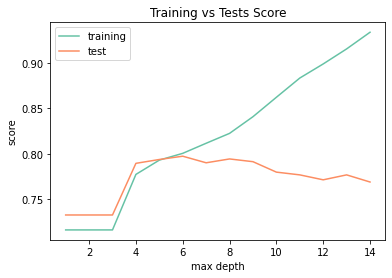

In [76]:
p1 = {
    'max_depth': 9,
    'min_samples_split': 10,
    'min_samples_leaf': 6,
    "random_state": 12
}

print_scores(p1)
print_scores()

df = pd.DataFrame([test_max_depth(md) for md in range(1, 15)])
plot_df(df)

df2 = pd.DataFrame([test_max_depth(md, p1) for md in range(1, 15)])
plot_df(df2)

Results
    Default hyperparameters result in largely overfitted model.
    Sweet spot for max depth is ~6 in isolation

In [58]:
#K-nearest neighbors

hyperparameters = {
    'leaf_size': [1,2,3],
    'n_neighbors': [1,2,3],
    "p":[1,2],
}

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, hyperparameters, cv=10, n_jobs=-1)
knn_model = knn_clf.fit(train_X, train_y)

knn_model_scores = pd.DataFrame(knn_model.cv_results_)
knn_model_scores[['param_leaf_size', 'param_n_neighbors', 'param_p', 'mean_test_score']]

,param_leaf_size,param_n_neighbors,param_p,mean_test_score
0,1,1,1,0.731929
1,1,1,2,0.729516
2,1,2,1,0.731328
3,1,2,2,0.730316
4,1,3,1,0.760389
5,1,3,2,0.757566
6,2,1,1,0.731929
7,2,1,2,0.729516
8,2,2,1,0.731328
9,2,2,2,0.730316


In [59]:
#SVM

hyperparameters = {
    'C': [0.1], 
    'gamma': [1], 
    'kernel': ['rbf']
}

svc = SVC()
svc_clf = GridSearchCV(svc, hyperparameters, cv=10, n_jobs=-1)
svc_model = svc_clf.fit(train_X, train_y)

svc_model_scores = pd.DataFrame(svc_model.cv_results_)
svc_model_scores[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score']]

,param_C,param_gamma,param_kernel,mean_test_score
0,0.1,1,rbf,0.502423
